## AIDI 2004 - AI in Enterprise Systems

### FINAL PROJECT

by Michael Molnar and Vasundara Chandre Gowda

Condensing long passages of text into short and representative snippets is a important task in natural language processing.  People can often be left frustrated at the end of reading an article, having found they had been fooled by a sensation, clickbait headline. 

In this project we will train and build our own deep learning model that will generate a novel summary that captures the main points of a news article, product review, or other text sample.    

We will build a web application and deploy our model for use. 

### NOTEBOOK 2:

In this notebook we will load our cleaned dataset.  We will examine the lenghts of the review texts and sumamries and then begin the process of building and training our abstractive summarization model. 

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import pickle

### Loading the Cleaned Data

In [2]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_reviews.csv')
df.head()

,Unnamed: 0,Summary,Text,cleaned_text,cleaned_summary
0,0,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,_START_ good quality dog food _END_
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,_START_ not as advertised _END_
2,2,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,_START_ delight says it all _END_
3,3,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,_START_ cough medicine _END_
4,4,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,_START_ great taffy _END_


### Getting the Lengths of the Cleaned Text and Cleaned Summaries

In [3]:
# Count the number of tokens in each cleaned_text
df['cleaned_text_words'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

In [4]:
# Get the statistics
df['cleaned_text_words'].describe()

count    394618.000000
mean         39.464627
std          39.202397
min           1.000000
25%          17.000000
50%          28.000000
75%          48.000000
max        1974.000000
Name: cleaned_text_words, dtype: float64

We see that the average review text is now about 40 words (it was about 80 before the pre-processing).  Three quarters of all the reviews are 48 words or less.

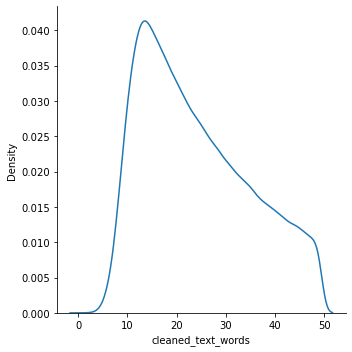

In [5]:
# Plot the cleaned text lengths as a density plot
sns.displot(x = 'cleaned_text_words', data = df[df['cleaned_text_words'] < 50], kind = 'kde')

Filtering for reviews under 50 words, we see that the density plot shows the most common review length is slightly less than 20 words.  

In [6]:
# Count the number of tokens in each cleaned_summary
df['cleaned_summary_words'] = df['cleaned_summary'].apply(lambda x: len(str(x).split()))

In [7]:
# Get the statistics
df['cleaned_summary_words'].describe()

count    394618.000000
mean          5.962455
std           2.449166
min           3.000000
25%           4.000000
50%           5.000000
75%           7.000000
max          30.000000
Name: cleaned_summary_words, dtype: float64

Since we have added starting and ending tokens to our summaries, our average length has increased to 6 tokens.  We see that three quarters of our summaries are 7 tokens or less, while the maximum has dropped from 42 (before pre-processing) to 30. 

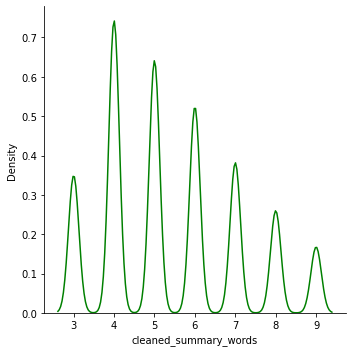

In [8]:
# Plot cleaned summary lengths as a density plot
sns.displot(x = 'cleaned_summary_words', data = df[df['cleaned_summary_words'] < 10], kind = 'kde', color = 'green')

Filtering for summaries under 10 tokens, we see that the density plot shows the most common summary lenghts are 4 or 5 tokens.

We want to determine an appropriate length at which to limit our summary generation model.  We first check how many rows we will have if we limit the to only summaries 10 tokens or less.

In [9]:
# Filter by rows with cleaned summaries less than 10 tokens long
df10 = df[df['cleaned_summary_words'] < 10]
df10.shape

(360112, 7)

We see that this leaves us still with over 360k rows.  Now, we will filter this again, removing any rows where the cleaned text exceeds 50 words.

In [10]:
# Further filter by rows with cleaned text less than 50 words long
df50_10 = df10[df10['cleaned_text_words'] < 50]
df50_10.shape

(283199, 7)

We are left with over 283k rows.  We will now define two thresholds - one for the maximum length of the text, and one for the maximum length of the summary.  Before we do that, however, to reduce the training time of the model and avoid potential memory issues, we will restrict our dataset to a sample of 100k rows.

In [13]:
# Select 100k rows at random from the dataset
df_sample = df50_10.sample(n = 100000, random_state = 0)

In [15]:
MAX_LEN_TEXT = 50
MAX_LEN_SUMMARY = 10

### Splitting into Training and Testing Datasets

We will split our data into two sets - 90% for training and 10% for testing.

In [19]:
# Define our X and our y 
X = df_sample['cleaned_text']
y = df_sample['cleaned_summary']

In [20]:
# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [21]:
# Print the sizes 
print('Size of X_train:', X_train.shape)
print('Size of y_train:', y_train.shape)
print('Size of y_test:', y_test.shape)
print('Size of y_test:', y_test.shape)

Size of X_train: (90000,)
Size of y_train: (90000,)
Size of y_test: (10000,)
Size of y_test: (10000,)


### Tokenizing the Data

#### Tokenize the Review Text

In [22]:
# Define a Tokenizer object
text_tokenizer = Tokenizer()
# Fit on the X_train data
text_tokenizer.fit_on_texts(list(X_train))

In [23]:
# Convert the X data into integer sequences 
X_train = text_tokenizer.texts_to_sequences(X_train)
X_test = text_tokenizer.texts_to_sequences(X_test)

In [24]:
# Apply padding to ensure that all sequences are the same length
X_train = pad_sequences(X_train, maxlen = MAX_LEN_TEXT, padding = 'post')
X_test = pad_sequences(X_test, maxlen = MAX_LEN_TEXT, padding = 'post')

In [25]:
# Get the vocabulary size for the review text data
x_vocab_size = len(text_tokenizer.word_index) + 1
print('Text Vocab Size:', x_vocab_size)

Text Vocab Size: 40080


#### Tokenize the Summary Text

In [26]:
# Define a Tokenizer object
summary_tokenizer = Tokenizer()
# Fit on the y_train data
summary_tokenizer.fit_on_texts(list(y_train))

In [27]:
# Convert the y data into integer sequences 
y_train = summary_tokenizer.texts_to_sequences(y_train)
y_test = summary_tokenizer.texts_to_sequences(y_test)

In [28]:
# Apply padding to ensure that all sequences are the same length
y_train = pad_sequences(y_train, maxlen = MAX_LEN_SUMMARY, padding = 'post')
y_test = pad_sequences(y_test, maxlen = MAX_LEN_SUMMARY, padding = 'post')

In [29]:
# Get the vocabulary size for the summary text data
y_vocab_size = len(summary_tokenizer.word_index) + 1
print('Summary Vocab Size:', y_vocab_size)

Summary Vocab Size: 14303


In [70]:
# Save the cleaned datasets
np.savetxt('X_train.csv', X_train, delimiter = ',')
np.savetxt('X_test.csv', X_test, delimiter = ',')
np.savetxt('y_train.csv', y_train, delimiter = ',')
np.savetxt('y_test.csv', y_test, delimiter = ',')

### Building the Model

There are two phases to this project - training and infernece - and each will make use of its own models.  Our task is a many-to-many sequence-to-sequence task, where are input and output sequences are different lenghts.  As such, we are making use of a LSTM encoder-decoder architecture.

#### Building the Training Model

In [30]:
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(MAX_LEN_TEXT,))
enc_emb = Embedding(x_vocab_size, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm1(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm1(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_vocab_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_ouputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense Layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_ouputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [31]:
# Print the model summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 500)      20040000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 500), (N 2002000     embedding[0][0]                  
                                                                 lstm[0][0]                       
                                                                 lstm[1][0]                       
_______________________________________________________________________________________

In [32]:
# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [33]:
# Define an early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [34]:
# Train the model
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=50, callbacks=[es], batch_size=512, 
                  validation_data=([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
176/176 [==============================] - 1107s 6s/step - loss: 2.7253 - val_loss: 2.3212
Epoch 2/50
176/176 [==============================] - 1194s 7s/step - loss: 2.3044 - val_loss: 2.1687
Epoch 3/50
176/176 [==============================] - 1177s 7s/step - loss: 2.1770 - val_loss: 2.0906
Epoch 4/50
176/176 [==============================] - 1158s 7s/step - loss: 2.0849 - val_loss: 2.0292
Epoch 5/50
176/176 [==============================] - 1103s 6s/step - loss: 2.0016 - val_loss: 1.9781
Epoch 6/50
176/176 [==============================] - 1106s 6s/step - loss: 1.9270 - val_loss: 1.9283
Epoch 7/50
176/176 [==============================] - 1080s 6s/step - loss: 1.8588 - val_loss: 1.8957
Epoch 8/50
176/176 [==============================] - 1084s 6s/step - loss: 1.7968 - val_loss: 1.8710
Epoch 9/50
176/176 [==============================] - 1082s 6s/step - loss: 1.7385 - val_loss: 1.8571
Epoch 10/50
176/176 [==============================] - 1076s 6s/step - loss: 1.682

In [49]:
# Save the model
model.save('model.h5')

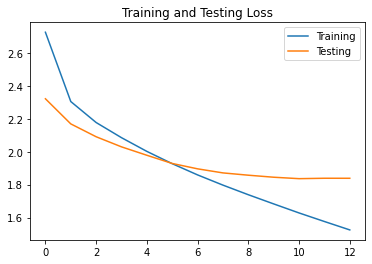

In [52]:
# Plot the training and testing losses
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Testing')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

After training and evaluating the model, we see the results look very promising.  

We save our tokenizers, as we did our model, for future use elsewhere. 

In [54]:
# Save the tokenizers
pickle.dump(text_tokenizer, open('text_tokenizer.pkl', 'wb'))
pickle.dump(summary_tokenizer, open('summary_tokenizer.pkl', 'wb'))

#### Building the Inference Models

Now that our training model has been built, we are ready for the actual summarization process.  To do this we define two models - an encoder and a decoder.  First, we use the tokenizers to create mappings between the integer sequences of our input and output and the actual words they correspond to in our vocabularies.

In [55]:
reverse_target_word_index = summary_tokenizer.index_word 
reverse_source_word_index = text_tokenizer.index_word 
target_word_index = summary_tokenizer.word_index

#### Build the Encoder and Decoder Inference Models

In [56]:
# Encoder inference
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(MAX_LEN_TEXT, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [57]:
# Save the encoder model 
encoder_model.save('encoder_model.h5')

In [58]:
# Save the decoder model
decoder_model.save('decoder_model.h5')

### Producing Summaries

We now use these models to produce our summaries.  

In [59]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (MAX_LEN_SUMMARY-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In this section we will evaluate our model on our testing data.  To do this we make use of the mappings we created with our tokenizers.  We must convert the integers of the input and output sequences to their corresponding English words.

In [60]:
def seq2summary(input_seq):
    """
    Take the summary sequence and retrieve the words from the summary tokenizer.
    """
    newString=''
    for i in input_seq:
        if ((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    """
    Take the input sequence and retrieve the words from the text tokenizer.
    """
    newString=''
    for i in input_seq:
        if (i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

We use the models and these functions to generate summaries for the first 100 rows of the testing data.  For each of these, we compare the generated summary to the actual summary. 

In [61]:
for i in range(100):
    print("Review:",seq2text(X_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(X_test[i].reshape(1, MAX_LEN_TEXT)))
    print("\n")

Review: glad find amazon looking store long time absolutely makes best cheeseball alternatives better nothing makes delish 
Original summary: simply the best 
Predicted summary:  best ever


Review: bought product review read said dissolved easily dissolve cold broth clumps heating mess cooked egg powder hard lumps one nauseous chemo trying get nutrition satisfactory secret method make work packaging 
Original summary: does not dissolve easily 
Predicted summary:  not what expected


Review: two boxes tea bags really great tea white tea best tea 
Original summary: best tea 
Predicted summary:  great tea


Review: great item daughter came back summer camp wanted healthy loaded vitamin could find local stores found amazon bought couple cases 
Original summary: nuggets 
Predicted summary:  great product


Review: satisfied quick delivery course barry decaf tea best decaf tea tried full bodied staple mine years bought amazon br br peggy 
Original summary: barry irish breakfast tea decaf 
P

Predicted summary:  disgusting


Review: subscription buy take camping instead dragging along milk needs cooler give daughter milk lunch since allergic animal milks school great snack craving something sweet feel better getting protein calcium sugar rush pop one bag way work without cooler needed even use one mix coffee afternoons mocha latte 
Original summary: convenient and great taste 
Predicted summary:  my son favorite


Review: tasted brands flax milk brand best far creamy brands really creamy slight taste little nutty guess cannot wait order amazon hope shipping reasonable 
Original summary: the best flax milk on the market 
Predicted summary:  best ever


Review: really nice aroma opened packet mixture lemon ginger taste lemon particularly hold mouth moment ginger taste really prevalent flavor kick get eat fresh pickled ginger enjoy drink weird unpleasant aftertaste would like something like actual product probably would make grocery cart 
Original summary: strong ginger taste 

Predicted summary:  not what was expecting


Review: find tassimo coffee maker along coffee products beyond belief great items 
Original summary: great coffee 
Predicted summary:  coffee


Review: need gluten free product diet good eat gluten free readily available local stores online purchase much appreciated 
Original summary: maple buckwheat flakes gluten free 
Predicted summary:  great gluten free pasta


Review: purchased starbucks whim starving figured would give whirl subscription delivery amazon product best potato chip problem finish whole bag crack open second third defeats purpose trying eat little healthier chip oh well damn good 
Original summary: you can not find better chip 
Predicted summary:  not what was expecting


Review: nuts oz jar knorr seasoning meat worth coming price br please get real smell roses 
Original summary: are you nuts 
Predicted summary:  not what expected


Review: bzz agent received coupon try package thomas bagel thins free buy regular bagels qui

Overall, we are very happy with these results.  The summaries are short, as were the training summaries, but for the most part they are very accurate when compared to the originals.  